<a href="https://colab.research.google.com/github/Kanchan786786/Capstone_project-/blob/main/Copy_of_Improved_LSTM_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner --upgrade


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import BayesianOptimization

<ipython-input-3-d292747a5cab>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
# Load and preprocess data
url = "https://raw.githubusercontent.com/Kanchan786786/Capstone_project-/main/aapl_scaled.csv"
df = pd.read_csv(url)

In [ ]:
features = ['High', 'Low', 'Open', 'Volume', 'VWAP', 'Market_Cap',
            'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist']
target = 'Close'

In [ ]:
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]),
#                          columns=features + [target],
#                          index=df.index)

In [ ]:
def create_sequences(data, feature_cols, target_col, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[feature_cols].iloc[i:i+time_steps].values)
        y.append(data[target_col].iloc[i+time_steps])
    return np.array(X), np.array(y)

In [ ]:
X, y = create_sequences(df, features, target)

In [ ]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Model builder for KerasTuner
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
import os


In [ ]:



# Updated model builder functionimport os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop

# Set seed for reproducibility
def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Updated model builder function
def build_model(hp):
    reset_seeds()  # Ensures reproducibility on every model build

    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        return_sequences = i < hp.get('num_layers') - 1
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=return_sequences,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=lr) if optimizer == 'adam' else RMSprop(learning_rate=lr)
    )

    return model

def build_model(hp):
    reset_seeds()  # Ensures reproducibility on every model build

    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        return_sequences = i < hp.get('num_layers') - 1
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=return_sequences,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=lr) if optimizer == 'adam' else RMSprop(learning_rate=lr)
    )

    return model


In [ ]:
# Tuner setup
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='stock_lstm')

Reloading Tuner from lstm_tuning/stock_lstm/tuner0.json


In [ ]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5)

In [ ]:

tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop, reduce_lr])

In [ ]:
# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Uncomment above two lines to run tuning

In [ ]:
# To train final model (placeholder):
model = build_model(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters)
history=model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
          callbacks=[early_stop, reduce_lr])

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0588 - val_loss: 0.0014 - learning_rate: 4.6642e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0101 - val_loss: 9.4568e-04 - learning_rate: 4.6642e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0065 - val_loss: 0.0014 - learning_rate: 4.6642e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0053 - val_loss: 2.3559e-04 - learning_rate: 4.6642e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0047 - val_loss: 2.8679e-04 - learning_rate: 4.6642e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0042 - val_loss: 0.0013 - learning_rate: 4.6642e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0037 - val_loss: 3.0093e-04 - learning_rate: 4.6642e-04
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0034 - val_loss: 4.4822e-04 - learning_rate: 2.3321e-04
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss:

In [ ]:
# Evaluate
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("Test MSE:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Test MSE: 0.15955047481129478


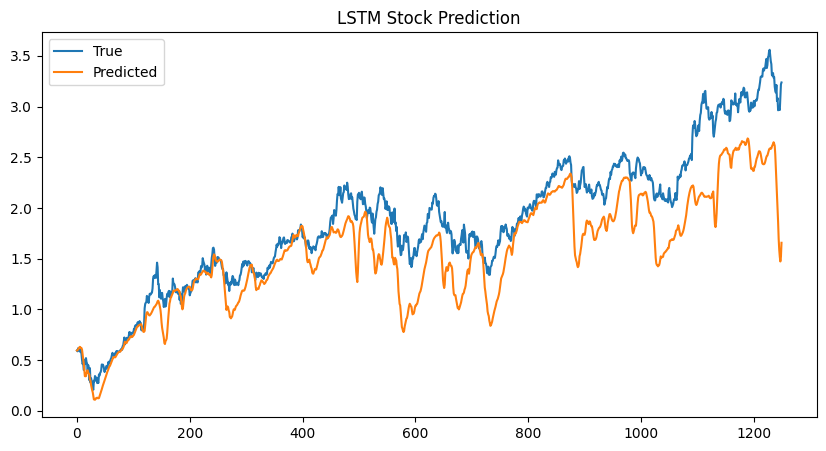

In [ ]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test, label='True')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('LSTM Stock Prediction')
plt.show()


In [ ]:
# prompt: i want see the r square for my model for both traing and testing

from sklearn.metrics import r2_score

# # Training R-squared
# train_preds = model.predict(X_train)
# train_r2 = r2_score(y_train, train_preds)
# print(f"Training R-squared: {train_r2}")


test_r2 = r2_score(y_test, preds)
print(f"Testing R-squared: {test_r2}")


Testing R-squared: 0.661041842378361


In [ ]:
# # prompt: I want to see the feature improtance for all of the columns

# import pandas as pd
# import numpy as np
# # Split data into features (X) and target (y)
# X = df[features]
# y = df[target]

# # Split data into training and testing sets
# split_index = int(len(df) * 0.8)
# X_train, X_test = X[:split_index], X[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]


# # Define the model
# def build_model(hp):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
#                                  return_sequences=True,
#                                  activation='relu',
#                                  input_shape=(X_train.shape[1], 1))))  # Corrected input shape
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
#     model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
#                    activation='relu'))
#     model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
#     model.add(Dense(units=1))
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#         loss='mean_squared_error',
#         metrics=['mse'])
#     return model

# tuner = BayesianOptimization(
#     build_model,
#     objective='mse',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='./',
#     project_name='LSTM_tuning')


# tuner.search(x=np.array(X_train), y=np.array(y_train), epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get feature importances (Note: LSTM feature importances are not directly available like in tree-based models)
# We'll use the weights of the first layer to approximate feature importance
first_layer_weights = best_model.layers[0].get_weights()[0]
feature_importances = np.abs(np.mean(first_layer_weights, axis=1)) #Take the average across all units in the first LSTM layer.
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,Feature,Importance
0,High,0.002566
1,Low,0.000367
2,Open,0.002614
3,Volume,0.006476
4,VWAP,0.005187
5,Market_Cap,0.000962
6,SMA_50,0.002697
7,EMA_50,0.007654
8,RSI,0.004754
9,MACD,0.002730


# Model Summary for APPLE
| Model | Activation Function | No.of Layer| Layer_lstm | Dropout (Y/N)|Test Accuracy |No.of epoch|Number of Dropout layer |Droping Rate|Explanation for change | outcome||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| LSTM_1 | Relu | 6 | 50/LSTM_Layer1,50/LSTM_layer2|Y|0.6069 | 20 | 2|0.2 /both layer|it is our base model | base model |
| LSTM_2 | Relu | 6 | 50/LSTM_Layer1,50/LSTM_layer2|Y|-0.2286 |  40| 2|0.2 /both layer|Change in epoch | Accuracy decrease drastically |
|Improv | Relu | 6 | 200/LSTM_Layer1,150/LSTM_layer2|Y| 0.895|  50| 2|0.2 /both layer|Random search | got the best accuracy but overfitting model so far|
|Best_model | Relu/ | 6 | 200/LSTM_Layer1,150/LSTM_layer2|Y| 0.895|  50| 2|0.2 /both layer|Random search | got the best accuracy but overfitting model so far|

## Model Summary for the company Snapchat


| Model                     | Type | Layers/Params                    | Activation Function | Dropout Used | Dropout Rate       | Epochs |  Test Accuracy | Tuning Method           | Key Notes                                       | Outcome                              |
|:------------------------:|:----:|:--------------------------------:|:-------------------:|:------------:|:------------------:|:------:|:---------------:|:------------------------:|:-----------------------------------------------:|:------------------------------------:|
| LSTM_1                   | DL   | 50/LSTM_Layer1, 50/LSTM_Layer2   | ReLU                | Y            | 0.2 / both layers  | 20     |  0.6069         | Base Model              | It is our base model                            | Base model                           |
| LSTM_2                   | DL   | 50/LSTM_Layer1, 50/LSTM_Layer2   | ReLU                | Y            | 0.2 / both layers  | 40     |  -0.2286        | Epoch changed           | Overfitting likely due to too many epochs       | Worse than base                      |
| LSTM with Random Search  | DL   | 50/LSTM_Layer1, 50/LSTM_Layer2   | ReLU                | Y            | 0.2 / both layers  | 30     |  0.775157       | Random Search           | Tuning helped boost performance                 | Better than base                     |
| LSTM with BayesianOptimization | DL | 50/LSTM_Layer1, 50/LSTM_Layer2   | ReLU                | Y            | 0.2 / both layers  | 30     |  0.68708888      | Bayesian Optimization    | Moderate improvement, still below Random Search | Slight improvement                   |
| ARIMA                    | TS   | p,d,q (default)                  | N/A                 | N            | N/A                | N/A    |  -0.1374244300   | Random Search           | Non-stationary data; needs differencing         | Try stationarizing data              |
| SARIMA                   | TS   | (p,d,q)(P,D,Q,s)                 | N/A                 | N            | N/A                | N/A    | -0.266487648     | Random Search           | Captures seasonality but suffered overfitting   | Overfitting with seasonal terms      |
| Prophet                  | TS   | Additive Components              | N/A                 | N            | N/A                | N/A    |  -4.9700         | Random Search           | Easy to implement; severe overfitting           | High overfitting, poor performance   |
| SVM                      | ML   | Kernel=RBF, C=1                  | N/A                 | N            | N/A                | N/A    | 0.9594           | Random Search (gamma=0.01) | Excellent accuracy, classic model | Best accuracy but still scope to improvised    |


In [ ]:
from datetime import datetime

def summarize_model_performance(history, params=None, model_name="LSTM_Model"):
    """
    Summarize and analyze the performance of the LSTM model after training.
    """
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    train_mae = history.history.get('mae', history.history.get('mean_absolute_error', [None]))[-1]
    val_mae = history.history.get('val_mae', history.history.get('val_mean_absolute_error', [None]))[-1]

    # Feedback logic
    feedback = ""
    if val_loss > train_loss * 1.5:
        feedback = "⚠️ Model may be overfitting. Consider adding regularization or reducing complexity."
    elif train_loss > val_loss * 1.5:
        feedback = "⚠️ Model may be underfitting. Try training longer or increasing model capacity."
    elif abs(val_loss - train_loss) < 0.01:
        feedback = "✅ Model is well fit. Validation loss is close to training loss."
    else:
        feedback = "ℹ️ Model performance is reasonable, but worth tuning further."

    # Print summary
    print("="*60)
    print(f"📊 Model Summary: {model_name} | Run Time: {datetime.now()}")
    print("-" * 60)
    print(f"🔧 Hyperparameters: {params if params else 'Not Provided'}")
    print(f"📉 Final Training Loss: {train_loss:.4f}")
    print(f"📈 Final Validation Loss: {val_loss:.4f}")
    print(f"🧮 Final Training MAE: {train_mae:.4f}")
    print(f"🧪 Final Validation MAE: {val_mae:.4f}")
    print("-" * 60)
    print(f"🗣️ Feedback: {feedback}")
    print("="*60)


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on test set
preds = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print("🔍 Test MSE:", round(mse, 4))
print("📏 Test RMSE:", round(rmse, 4))


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
🔍 Test MSE: 0.1596
📏 Test RMSE: 0.3994


In [ ]:
# prompt: I want to write the summary from my result i the code format like take the result as variable and give me whole summary

def summarize_results(mse, rmse, test_r2, feature_importance_df):
    """Summarizes the model's performance and feature importances."""

    summary = f"""
    **Model Performance Summary**

    * **Mean Squared Error (MSE):** {mse:.4f}
    * **Root Mean Squared Error (RMSE):** {rmse:.4f}
    * **R-squared (R2):** {test_r2:.4f}


    **Feature Importances**

    """
    summary += feature_importance_df.to_string(index=False)

    return summary

# Example usage (assuming you have mse, rmse, test_r2, and feature_importance_df variables):
# Assuming 'feature_importance_df' is already calculated as in the original code.
# Replace with actual variable names from your code.
# summary = summarize_results(mse, rmse, test_r2, feature_importance_df)
# print(summary)


In [ ]:
summary = summarize_results(mse, rmse, test_r2, feature_importance_df)
print(summary)


    **Model Performance Summary**

    * **Mean Squared Error (MSE):** 0.1596
    * **Root Mean Squared Error (RMSE):** 0.3994
    * **R-squared (R2):** 0.6610


    **Feature Importances**

        Feature  Importance
       High    0.002566
        Low    0.000367
       Open    0.002614
     Volume    0.006476
       VWAP    0.005187
 Market_Cap    0.000962
     SMA_50    0.002697
     EMA_50    0.007654
        RSI    0.004754
       MACD    0.002730
MACD_Signal    0.004311
  MACD_Hist    0.000543
